In [3]:
import pandas as pd
import os
import hdbscan
import folium
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
import hdbscan
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from geopy.distance import geodesic
import folium
from folium import plugins
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


In [4]:
os.chdir('c:/Users/artur/OneDrive/Documents/TrabajoTesis') 


In [8]:
df = pd.read_csv('Cluster/df_faenas_y_desaladoras_y_puertos.csv')

In [9]:
#df = df.drop(columns = ['categorias_10km'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RutEmpresa               21158 non-null  object 
 1   NombreEmpresa            21158 non-null  object 
 2   CategoriaFaena           21158 non-null  object 
 3   RegionInstalacion        21158 non-null  object 
 4   TipoInstalacion          21158 non-null  object 
 5   Cota                     21158 non-null  int64  
 6   Huso                     21158 non-null  int64  
 7   Estado                   21158 non-null  object 
 8   Latitud                  21158 non-null  float64
 9   Longitud                 21158 non-null  float64
 10  faenas_10km              21158 non-null  int64  
 11  categorias_10km          21158 non-null  object 
 12  categoriaA_10km          21158 non-null  int64  
 13  Closest_City             21158 non-null  object 
 14  Distance_km           

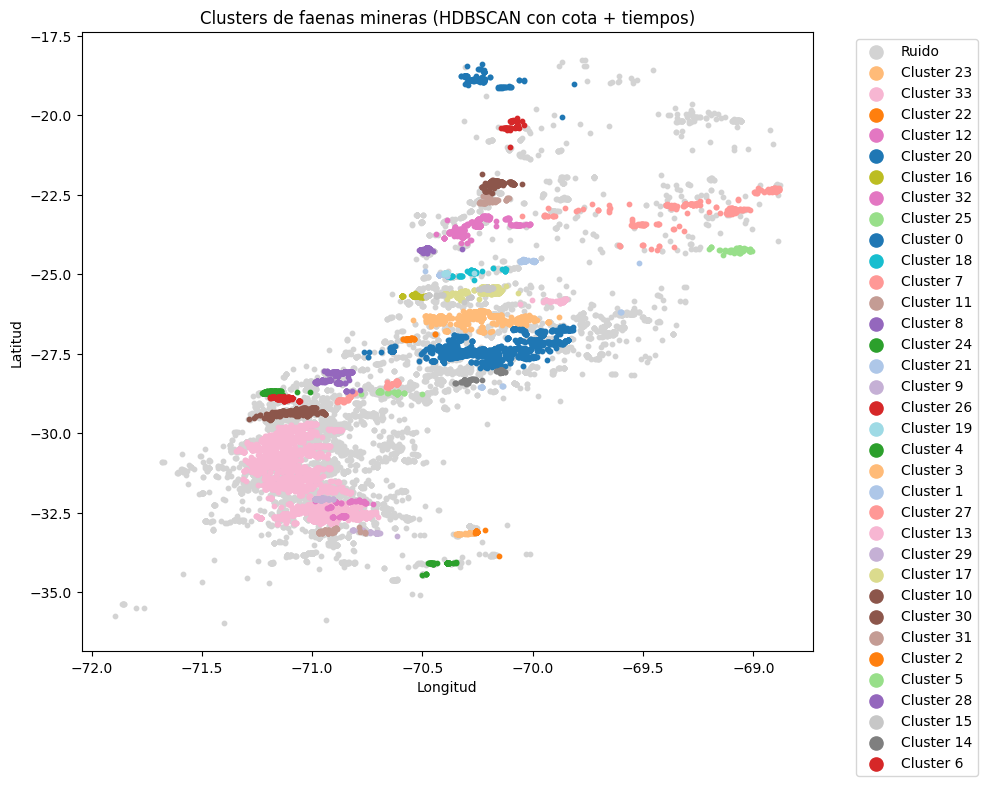

In [11]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 1: Select variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_filtered = df[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_filtered - df_filtered.mean()) / df_filtered.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df.loc[mask].copy()

# === Step 3: Scale the features (important for HDBSCAN) ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    cluster_selection_epsilon=0.4,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 25 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


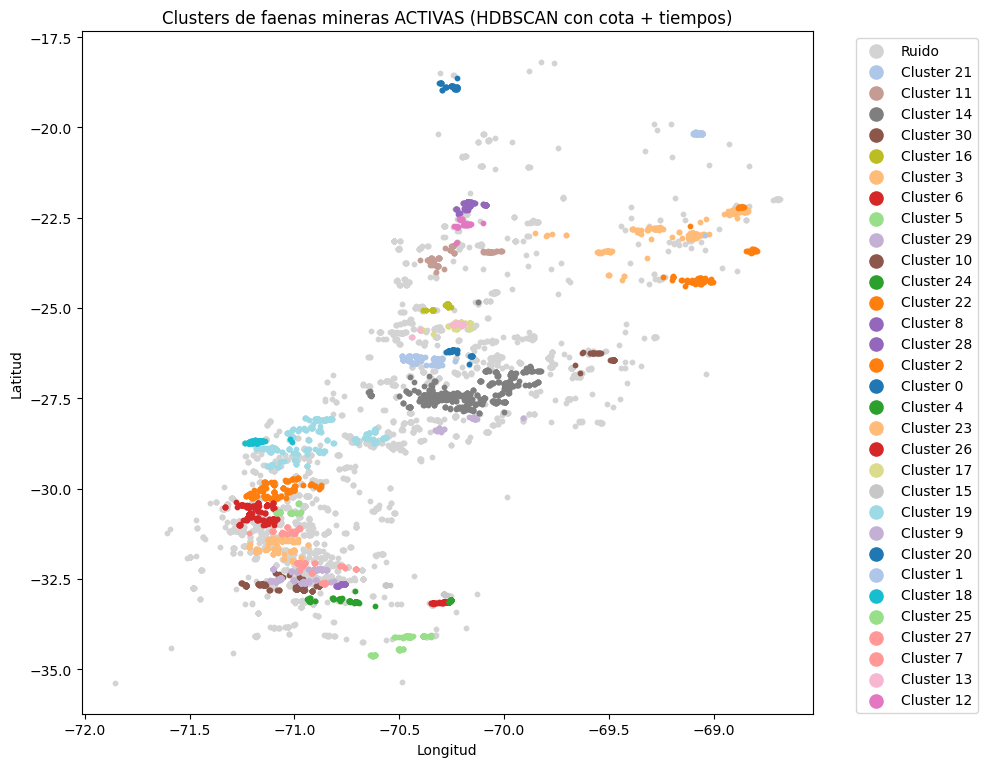

In [12]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filter only active sites ===
df_active = df[df["Estado"] == "ACTIVA"].copy()

# === Step 1: Select relevant variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Scale features ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.35,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 40 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [13]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")


C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4020827223.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


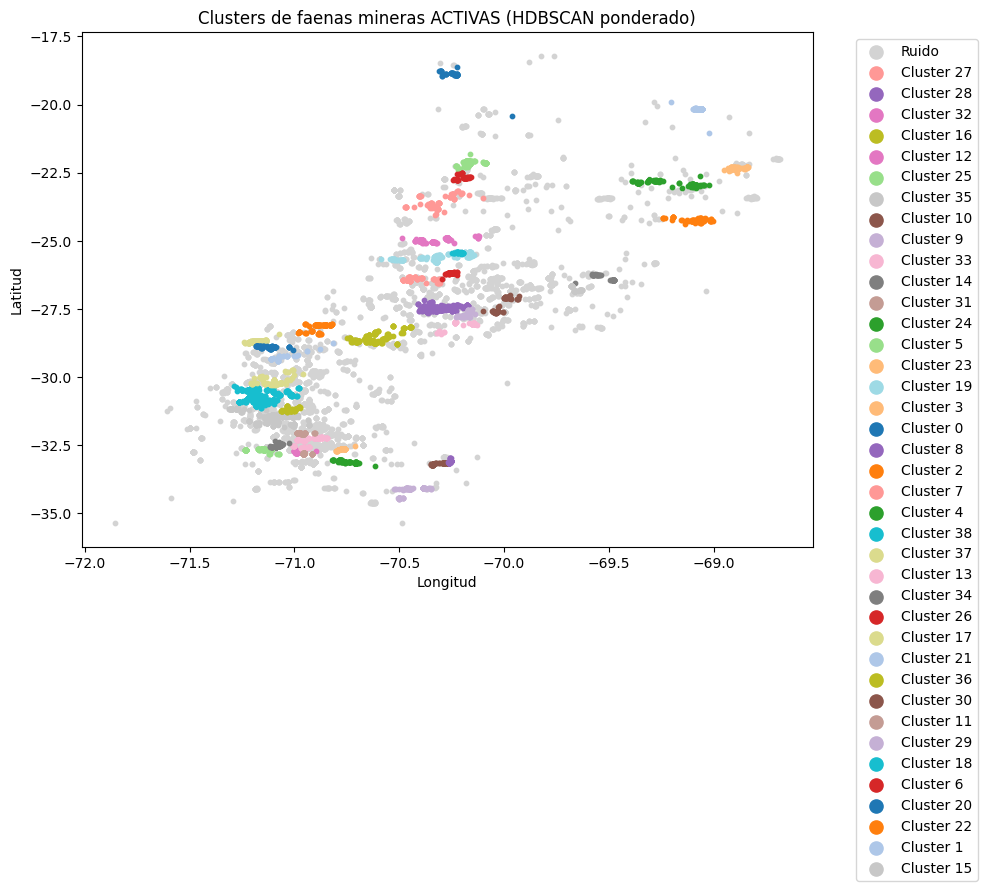

In [14]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filter only active sites ===
df_active = df[df["Estado"] == "ACTIVA"].copy()

# === Step 1: Select relevant variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Scale and weight features ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# ⚖️ Define feature weights (tune as needed)
weights = {
    'Longitud': 3.0,          # keep high (spatial importance)
    'Latitud': 3.0,           # keep high (spatial importance)
    'Cota': 0.5,              # less important
    'Travel_min': 1.5,        # more important
    'travel_time_desal': 0.5, # moderate
    'travel_time_min': 1.0    # baseline
}

# Apply weights
for i, f in enumerate(features):
    coords_scaled[:, i] *= weights[f]

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.4,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 40 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN ponderado)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [15]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")

C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4010231854.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


In [16]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")

C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4010231854.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


In [5]:
df_faenas2 = pd.read_csv('Cluster/df_faenas_5.csv')

In [18]:
df_faenas2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RutEmpresa          21158 non-null  object 
 1   NombreEmpresa       21158 non-null  object 
 2   CategoriaFaena      21158 non-null  object 
 3   RegionInstalacion   21158 non-null  object 
 4   TipoInstalacion     21158 non-null  object 
 5   Cota                21158 non-null  int64  
 6   Huso                21158 non-null  int64  
 7   Estado              21158 non-null  object 
 8   Latitud             21158 non-null  float64
 9   Longitud            21158 non-null  float64
 10  faenas_10km         21158 non-null  int64  
 11  Cat_A_10km          21158 non-null  int64  
 12  Ciudad_Cercana      21158 non-null  object 
 13  Est_Nombre          21158 non-null  object 
 14  Est_Dist            21158 non-null  float64
 15  Est_Tiempo          21158 non-null  float64
 16  Ciud

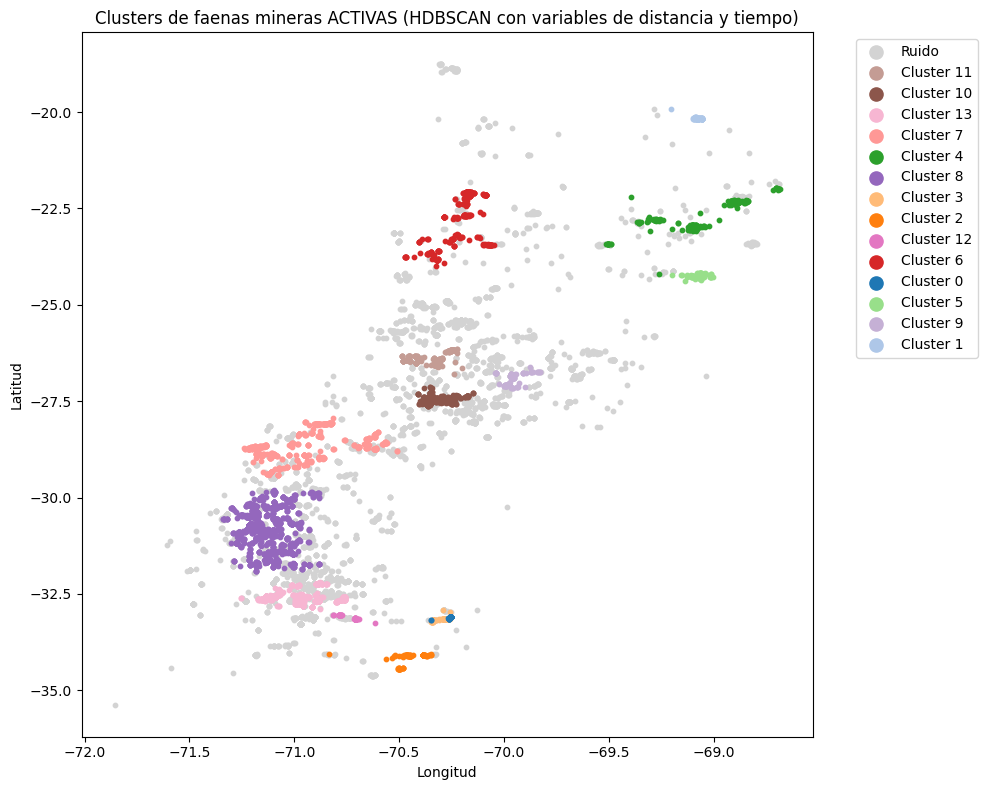

In [19]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filtrar faenas activas ===
df_active = df_faenas2[df_faenas2["Estado"] == "ACTIVA"].copy()

# === Step 1: Seleccionar variables relevantes ===
features = [
    'Longitud', 'Latitud', 'Cota',
     'Ciudad_Tiempo',
     'Est_Tiempo',
    'Desal_Dist_km', 
    'puerto_Tiempo',
     'lt_tiempo_min'
]

# Eliminar valores faltantes o infinitos
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remover outliers mediante Z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Escalar y ponderar variables ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# ⚖️ Pesos (ajustables según importancia)
weights = {
    'Longitud': 4.0,          # coordenadas espaciales
    'Latitud': 4.0,
    'Cota': 1.5,              # altura menor peso
    'Ciudad_Tiempo': 1,
    'Est_Tiempo': 1,
    'Desal_Dist_km': 1.5,     # acceso hídrico
    'puerto_Tiempo': 0.5,
    'lt_tiempo_min': 2.0
}

# Aplicar pesos
for i, f in enumerate(features):
    coords_scaled[:, i] *= weights[f]

# === Step 4: Clustering con HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=60,
    cluster_selection_epsilon=0.45,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Mantener los 40 clusters más grandes ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Visualización ===
plt.figure(figsize=(10, 8))
cmap = plt.colormaps.get_cmap('tab20')  # ✅ nuevo estilo sin warning

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con variables de distancia y tiempo)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [20]:
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='Esri.WorldImagery')
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % cmap.N)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    popup = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Tiempo LT:</b> {row['lt_tiempo_min']:.1f} min<br>
    <b>Tiempo Ciudad:</b> {row['Ciudad_Tiempo']:.1f} min<br>
    <b>Tiempo Puerto:</b> {row['puerto_Tiempo']:.1f} min<br>
    <b>Dist. Desaladora:</b> {row['Desal_Dist_km']:.1f} km
    """
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3, color=color, fill=True, fill_opacity=0.8,
        popup=folium.Popup(popup, max_width=250)
    ).add_to(m)

m.save('mining_clusters2.html')
print("🗺️ Mapa interactivo guardado como 'mining_clusters2.html'")


C:\Users\artur\AppData\Local\Temp\ipykernel_16656\1843138037.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🗺️ Mapa interactivo guardado como 'mining_clusters2.html'


In [21]:
df_faenas2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RutEmpresa          21158 non-null  object 
 1   NombreEmpresa       21158 non-null  object 
 2   CategoriaFaena      21158 non-null  object 
 3   RegionInstalacion   21158 non-null  object 
 4   TipoInstalacion     21158 non-null  object 
 5   Cota                21158 non-null  int64  
 6   Huso                21158 non-null  int64  
 7   Estado              21158 non-null  object 
 8   Latitud             21158 non-null  float64
 9   Longitud            21158 non-null  float64
 10  faenas_10km         21158 non-null  int64  
 11  Cat_A_10km          21158 non-null  int64  
 12  Ciudad_Cercana      21158 non-null  object 
 13  Est_Nombre          21158 non-null  object 
 14  Est_Dist            21158 non-null  float64
 15  Est_Tiempo          21158 non-null  float64
 16  Ciud

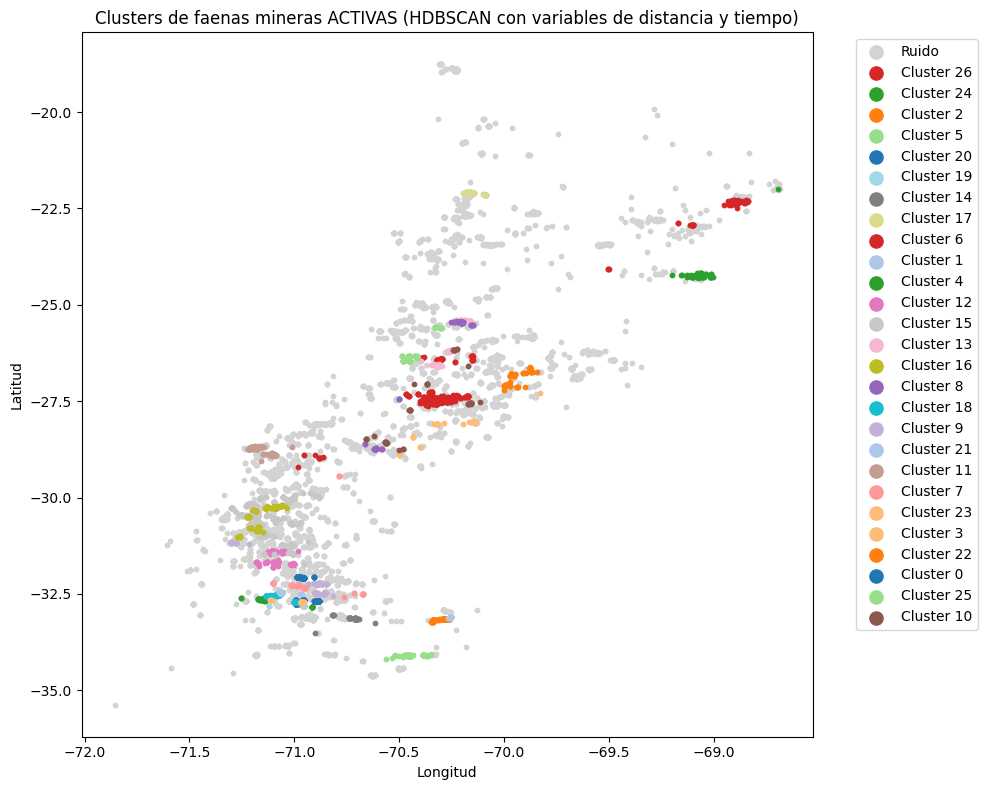

In [22]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filtrar faenas activas ===
df_active = df_faenas2[df_faenas2["Estado"] == "ACTIVA"].copy()

# === Step 1: Seleccionar variables relevantes ===
features = [
    'Longitud', 'Latitud', 'Cota',
     'Ciudad_Tiempo',
    'Est_Dist', 'Est_Tiempo',
    'Desal_Dist_km', 
    'puerto_Tiempo',
    'lt_dist_km'
]

# Eliminar valores faltantes o infinitos
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remover outliers mediante Z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Escalar y ponderar variables ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# ⚖️ Pesos (ajustables según importancia)
weights = {
    'Longitud': 1.0,          # coordenadas espaciales
    'Latitud': 1.0,
    'Cota': 1.0,              # altura menor peso
    'Ciudad_Tiempo': 1.0,
    'Est_Dist': 1.0,          # accesibilidad ferroviaria
    'Est_Tiempo': 3.0,
    'Desal_Dist_km': 1.0,     # acceso hídrico
    'puerto_Tiempo': 1.0,
    'lt_dist_km': 3.0,        # acceso energético
}

# Aplicar pesos
for i, f in enumerate(features):
    coords_scaled[:, i] *= weights[f]

# === Step 4: Clustering con HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.45,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Mantener los 40 clusters más grandes ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Visualización ===
plt.figure(figsize=(10, 8))
cmap = plt.colormaps.get_cmap('tab20')  # ✅ nuevo estilo sin warning

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con variables de distancia y tiempo)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [23]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
# Assuming df_clean is already defined and populated

# 1. Set the default map to 'OpenStreetMap' to show cities/regions
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='OpenStreetMap')

# 2. Add other tile layers you can switch to
folium.TileLayer(
    'Esri.WorldImagery',
    name='Satellite Imagery'
).add_to(m)

folium.TileLayer(
    'CartoDB positron',
    name='Light Map (Cities/Regions)'
).add_to(m)

# --- Your existing code for clusters ---
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % cmap.N)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    popup = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Tiempo Ciudad:</b> {row['Ciudad_Tiempo']:.1f} min<br>
    <b>Tiempo Puerto:</b> {row['puerto_Tiempo']:.1f} min<br>
    <b>Dist. Desaladora:</b> {row['Desal_Dist_km']:.1f} km
    """
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3, color=color, fill=True, fill_opacity=0.8,
        popup=folium.Popup(popup, max_width=250)
    ).add_to(m)
# --- End of your existing code ---

# 3. Add a LayerControl to the map
folium.LayerControl().add_to(m)

# Save the new map (I've updated the name slightly)
m.save('mining_clusters_with_layers.html')
print("🗺️ Mapa interactivo guardado como 'mining_clusters_with_layers.html'")

C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4092962241.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🗺️ Mapa interactivo guardado como 'mining_clusters_with_layers.html'


In [47]:
df = df_faenas2

In [48]:
df = df[df['Estado'] == "ACTIVA"]

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN  # <-- Importamos DBSCAN
import hdbscan
# geopy ya no es necesario para el Paso 1

# === Features to use ===
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# --- Filter and clean data ---
# (Usando los mismos datos de ejemplo de arriba)
df_clean = df.dropna(subset=clustering_features).copy()


# --- Step 1: Group by company (Optimizado con DBSCAN) ---

# DBSCAN con 'haversine' (distancia en la Tierra) necesita 'eps' en radianes.
# eps = (distancia_km / radio_tierra_km)
KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

# min_samples=1 significa que agrupará todo, incluso puntos solitarios
dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    
    # Preparamos coordenadas en radianes para haversine
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    
    # 1. Ejecutamos DBSCAN para encontrar sub-grupos
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels
    
    # 2. Iteramos sobre los sub-grupos encontrados y calculamos la media
    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        # No necesitamos borrar 'sub_cluster' del dict 'row'
        # porque no estaba en 'clustering_features'
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")


# --- Step 2: Standardize and apply weights (Sin cambios) ---
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

weights_balanced = {
    # Geografía (bajamos peso para que no dominen)
    'Longitud': 0.8,
    'Latitud': 0.8,
    'Cota': 0.7,

    # Logística (aumentamos para que HDBSCAN las use más)
    'Ciudad_Tiempo': 1.5,
    'Est_Tiempo': 1.5,
    'Desal_Dist_km': 1.3,
    'puerto_Tiempo': 1.3,
    'lt_tiempo_min': 1.4
}



X_weighted = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_weighted[:, i] *= weights_balanced[f]

# --- Step 3: HDBSCAN clustering (Sin cambios) ---
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,              # antes 10
    min_samples=2,                   # antes None
    cluster_selection_epsilon=0.15,   # antes 0.2
    metric='euclidean'
)

# Usamos .copy() para evitar SettingWithCopyWarning
df_grouped = df_grouped.copy()
df_grouped['cluster'] = clusterer.fit_predict(X_weighted)

print(f"✅ Clusters found: {len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'] else 0)}")
print(df_grouped['cluster'].value_counts())




✅ Total grouped points: 2281
✅ Clusters found: 39
cluster
-1     956
 17    277
 24    160
 35    114
 32     40
 10     34
 37     33
 6      32
 28     31
 26     28
 22     28
 2      26
 19     26
 34     25
 21     25
 36     24
 20     24
 11     24
 9      24
 33     20
 12     20
 31     20
 3      19
 13     19
 0      19
 23     18
 25     18
 1      18
 16     18
 30     17
 29     17
 27     17
 7      16
 5      16
 4      16
 15     16
 18     16
 14     15
 8      15
Name: count, dtype: int64


In [50]:
# Asumiendo que 'df_grouped' y 'clustering_features' ya existen

# Filtramos el ruido (-1) para el análisis
df_clusters = df_grouped[df_grouped['cluster'] != -1]

# Perfilamos los clusters
cluster_profile = df_clusters.groupby('cluster')[clustering_features].mean()

# === CAMBIO MENOR ===
# Añadimos .sort_index() para garantizar que los conteos 
# se alineen con el índice del cluster_profile (0, 1, 2...).
cluster_profile['MemberCount'] = df_clusters['cluster'].value_counts().sort_index()

print("--- Perfil de Clústers ---")
print(cluster_profile)

--- Perfil de Clústers ---
          Longitud    Latitud         Cota  Ciudad_Tiempo  Est_Tiempo  \
cluster                                                                 
0       -69.985244 -28.224597  2696.756287     180.431404  202.721228   
1       -70.236159 -18.789002   818.093305      68.463889   92.856852   
2       -70.405715 -26.504238  1139.983258      75.858631   82.665962   
3       -69.606620 -25.728703  2981.279031     266.711424  246.074649   
4       -70.967921 -32.078899  1768.430208     147.847500  155.047799   
5       -70.086564 -27.707341  2398.605208     175.658958  129.978958   
6       -69.274318 -23.965290  2601.494792     115.030443  162.501441   
7       -68.836812 -21.963270  3941.328125     134.763542   42.422604   
8       -70.130061 -27.990534  1986.032275     128.035000  135.386444   
9       -70.621380 -34.104284  1280.405093      47.190741   20.623750   
10      -69.098961 -24.236993  3019.558824     140.761152   22.522451   
11      -68.897343 -22.3

In [51]:
from sklearn.metrics import silhouette_score

# Asumiendo que 'df_grouped' y 'X_weighted' (los datos escalados Y ponderados) existen

# Prepara los datos
labels = df_grouped['cluster']

# === ARREGLO 1 (CRÍTICO) ===
# Debemos usar los mismos datos que se usaron para el clustering.
# Esta era la variable X_weighted (escalada Y ponderada).
data = X_weighted 

# === ARREGLO 2 (ROBUSTEZ) ===
# Creamos una máscara booleana y usamos .values para indexar el array de NumPy
mask = (labels != -1)
labels_true = labels[mask]
data_true = data[mask.values] # Usar .values es más seguro

# Necesitas al menos 2 clusters para calcular el score
if len(set(labels_true)) > 1:
    score = silhouette_score(data_true, labels_true, metric='euclidean')
    print(f"\n✅ Silhouette Score: {score:.3f}")
else:
    print("\nℹ️ No se puede calcular Silhouette Score (solo se encontró 1 cluster o puro ruido).")


✅ Silhouette Score: 0.257


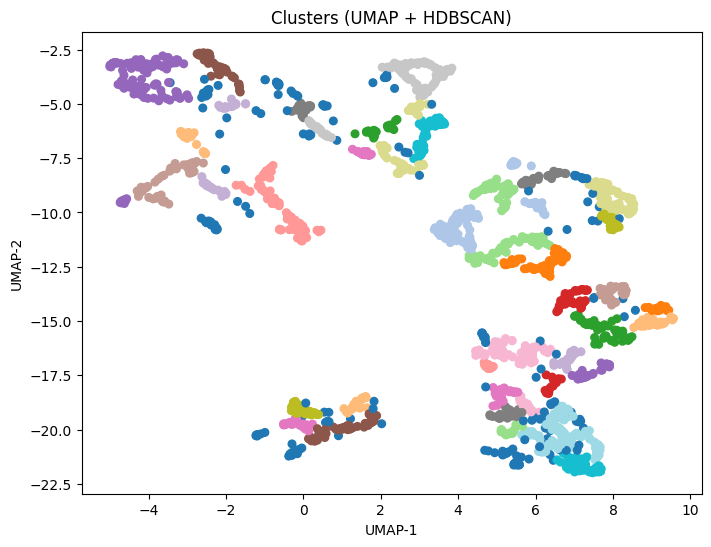

✅ Clusters detectados (UMAP + HDBSCAN): 68
cluster_umap
-1     149
 4      82
 62     77
 27     68
 52     66
      ... 
 47     16
 21     16
 64     16
 8      16
 54     15
Name: count, Length: 68, dtype: int64


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import hdbscan
import umap  # 👈 IMPORTACIÓN CORRECTA

# Escalamos igual que antes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# Aplicamos pesos balanceados
X_weighted = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_weighted[:, i] *= weights_balanced[f]

# --- Paso 1: UMAP ---
reducer = umap.UMAP(
    n_neighbors=20,
    min_dist=0.2,
    n_components=2,
    metric='manhattan',
    random_state=42
)

X_umap = reducer.fit_transform(X_weighted)

# --- Paso 2: HDBSCAN ---
clusterer_umap = hdbscan.HDBSCAN(
    min_cluster_size=15,              # antes 10
    min_samples=2,                   # antes None
    cluster_selection_epsilon=0.15,   # antes 0.2
    metric='euclidean'
)

df_grouped['cluster_umap'] = clusterer_umap.fit_predict(X_umap)

# --- Paso 3: Visualización ---
plt.figure(figsize=(8,6))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=df_grouped['cluster_umap'],
    cmap='tab20',
    s=30
)
plt.title("Clusters (UMAP + HDBSCAN)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

# --- Paso 4: Resumen ---
n_clusters = len(set(df_grouped['cluster_umap'])) - (1 if -1 in df_grouped['cluster_umap'] else 0)
print(f"✅ Clusters detectados (UMAP + HDBSCAN): {n_clusters}")
print(df_grouped['cluster_umap'].value_counts())




In [57]:
from sklearn.metrics import silhouette_score

# Filtramos los puntos con cluster válido
mask_valid = df_grouped['cluster_umap'] != -1
X_valid = X_weighted[mask_valid]
labels_valid = df_grouped.loc[mask_valid, 'cluster_umap']

if len(set(labels_valid)) > 1:
    sil_score = silhouette_score(X_valid, labels_valid)
    print(f"🔹 Silhouette Score: {sil_score:.3f}")
else:
    print("⚠️ No se puede calcular el Silhouette Score (solo hay un cluster válido).")


🔹 Silhouette Score: 0.159


In [102]:
df_grouped[clustering_features].describe()


,Longitud,Latitud,Cota,Ciudad_Tiempo,Est_Tiempo,Desal_Dist_km,puerto_Tiempo,lt_tiempo_min
count,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000
mean,-70.409496,-28.073183,1359.664356,90.849787,66.178577,87.458425,142.398855,59.824926
std,0.684953,3.605110,901.733600,80.139992,83.182563,49.865369,90.093005,88.276947
min,-71.855938,-35.373485,0.000000,3.000000,0.325000,0.164000,0.103333,0.000000
25%,-70.989517,-31.135086,746.666667,45.108333,22.563750,51.050000,86.877222,21.180000
50%,-70.465613,-28.108292,1080.142857,75.100000,46.318333,74.377500,124.939167,37.820167
75%,-70.099920,-25.721509,1723.600000,114.246429,79.352917,122.018636,181.364792,68.010417
max,-67.066619,-18.198667,5322.000000,1793.600000,1810.396667,327.030000,1844.953333,2149.330000


In [ ]:
# ==========================================================
# --- Step: Sub-clustering the largest cluster using 2 km company grouping ---
# ==========================================================

# Identify the largest cluster (excluding outliers)
cluster_counts = df_grouped['cluster'].value_counts()
largest_cluster_id = cluster_counts.drop(-1, errors='ignore').idxmax()
print(f"Largest cluster: {largest_cluster_id}, {cluster_counts[largest_cluster_id]} points")

# Filter points from the largest cluster
df_largest_points = df_grouped[df_grouped['cluster'] == largest_cluster_id].copy()

# --- Step 1: Group by company within 2 km radius (sub-clustering) ---
grouped_points_sub = []

for empresa, group in df_largest_points.groupby("NombreEmpresa"):
    coords = list(zip(group["Latitud"], group["Longitud"]))
    used = set()
    for i, coord in enumerate(coords):
        if i in used:
            continue
        nearby_indices = [i]
        for j, other_coord in enumerate(coords):
            if i != j and j not in used:
                if geodesic(coord, other_coord).km <= 2.0:  # 2 km radius for sub-clustering
                    nearby_indices.append(j)
        for idx in nearby_indices:
            used.add(idx)
        
        subset = group.iloc[nearby_indices]
        row = subset.mean(numeric_only=True).to_dict()
        row["Latitud"] = subset["Latitud"].mean()
        row["Longitud"] = subset["Longitud"].mean()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points_sub.append(row)

df_largest_grouped = pd.DataFrame(grouped_points_sub)
print(f"✅ Total grouped points for sub-clustering: {len(df_largest_grouped)}")

# --- Step 2: Standardize and apply weights ---
scaler_sub = StandardScaler()
X_scaled_sub = scaler_sub.fit_transform(df_largest_grouped[clustering_features])

weights_sub = {
    'Longitud': 1.0, 'Latitud': 2.0, 'Cota': 1.0, 'Ciudad_Tiempo': 1.0,
    'Est_Tiempo': 2.0, 'Desal_Dist_km': 1.0, 'puerto_Tiempo': 1.0, 'lt_tiempo_min': 1.0
}
for i, f in enumerate(clustering_features):
    X_scaled_sub[:, i] *= weights_sub[f]

# --- Step 3: HDBSCAN sub-clustering ---
sub_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,  # Ajusta según quieras más sub-clusters
    cluster_selection_epsilon=0.1,
    metric='euclidean'
)
df_largest_grouped['sub_cluster'] = sub_clusterer.fit_predict(X_scaled_sub)

print(f"✅ Sub-clusters in largest cluster: {len(set(df_largest_grouped['sub_cluster'])) - (1 if -1 in df_largest_grouped['sub_cluster'] else 0)}")
print(df_largest_grouped['sub_cluster'].value_counts())




Largest cluster: 17, 416 points
✅ Total grouped points for sub-clustering: 389
✅ Sub-clusters in largest cluster: 5
sub_cluster
-1    260
 3     49
 2     45
 1     23
 0     12
Name: count, dtype: int64


In [96]:
df_grouped[clustering_features].describe()


,Longitud,Latitud,Cota,Ciudad_Tiempo,Est_Tiempo,Desal_Dist_km,puerto_Tiempo,lt_tiempo_min
count,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000
mean,-70.409496,-28.073183,1359.664356,90.849787,66.178577,87.458425,142.398855,59.824926
std,0.684953,3.605110,901.733600,80.139992,83.182563,49.865369,90.093005,88.276947
min,-71.855938,-35.373485,0.000000,3.000000,0.325000,0.164000,0.103333,0.000000
25%,-70.989517,-31.135086,746.666667,45.108333,22.563750,51.050000,86.877222,21.180000
50%,-70.465613,-28.108292,1080.142857,75.100000,46.318333,74.377500,124.939167,37.820167
75%,-70.099920,-25.721509,1723.600000,114.246429,79.352917,122.018636,181.364792,68.010417
max,-67.066619,-18.198667,5322.000000,1793.600000,1810.396667,327.030000,1844.953333,2149.330000


In [60]:
import folium
from matplotlib import cm, colors
from folium import plugins

# --- Map setup ---
map_center = [df_clean['Latitud'].mean(), df_clean['Longitud'].mean()]
m = folium.Map(location=map_center, zoom_start=5, tiles='CartoDB positron')

# --- Color setup for first-level clusters ---
unique_clusters = sorted(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', len(unique_clusters))
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(unique_clusters)}
color_dict[-1] = 'lightgray'  # outliers

# --- Layer 1: All faenas (first-level clusters) ---
layer_all = folium.FeatureGroup(name="⛏️ All Faenas (First-Level)", show=True)
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = color_dict.get(cluster_id, 'black')
    popup_text = f"<b>Empresa:</b> {row.get('NombreEmpresa','N/A')}<br><b>Cluster:</b> {cluster_id}"
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3, color=color, fill=True, fill_color=color,
        fill_opacity=0.6 if cluster_id != -1 else 0.3,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(layer_all)
layer_all.add_to(m)

# --- Layer 2: Sub-clusters in largest cluster ---
df_largest['sub_cluster_label'] = df_largest['sub_cluster'].apply(lambda x: f"{largest_cluster_id}-{x}")
unique_sub = sorted(df_largest['sub_cluster'].unique())
cmap_sub = cm.get_cmap('Set1', len(unique_sub))
color_dict_sub = {c: colors.to_hex(cmap_sub(i % 9)) for i, c in enumerate(unique_sub)}
color_dict_sub[-1] = 'lightgray'

layer_sub = folium.FeatureGroup(name=f"🌟 Sub-Clusters in Cluster {largest_cluster_id}", show=True)
for _, row in df_largest.iterrows():
    sub_id = row['sub_cluster']
    color = color_dict_sub.get(sub_id, 'black')
    popup_text = f"<b>Empresa:</b> {row.get('NombreEmpresa','N/A')}<br><b>Sub-Cluster:</b> {row['sub_cluster_label']}"
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4, color=color, fill=True, fill_color=color,
        fill_opacity=0.7 if sub_id != -1 else 0.3,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(layer_sub)
layer_sub.add_to(m)

# --- Layer 3: Special faenas (CATEGORIA A y minas) ---
df_special = df_clean[
    (df_clean['CategoriaFaena'] == 'CATEGORIA A') &
    (df_clean['TipoInstalacion'].isin(['MINA SUBTERRANEA', 'MINA RAJO ABIERTO']))
].copy()

layer_special = folium.FeatureGroup(name="🔴 CATEGORIA A - MINAS", show=False)
for _, row in df_special.iterrows():
    popup_text = f"<b>Empresa:</b> {row.get('NombreEmpresa','N/A')}<br><b>Tipo:</b> {row['TipoInstalacion']}"
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(layer_special)

layer_special.add_to(m)



# --- Add OSM & Satellite Tiles (with attribution) ---
folium.TileLayer(
    'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
    name="🗺️ OpenStreetMap",
    attr="© OpenStreetMap contributors"
).add_to(m)

folium.TileLayer(
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    name='🛰️ Satellite',
    attr="© Esri"
).add_to(m)


# --- Add controls ---
plugins.LocateControl().add_to(m)
plugins.Fullscreen().add_to(m)
folium.LayerControl().add_to(m)

# --- Save map ---
m.save("faenas_clusters_map.html")
print("✅ Map saved as 'faenas_clusters_map.html'")






C:\Users\artur\AppData\Local\Temp\ipykernel_16656\3540425673.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(unique_clusters))
C:\Users\artur\AppData\Local\Temp\ipykernel_16656\3540425673.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_sub = cm.get_cmap('Set1', len(unique_sub))


✅ Map saved as 'faenas_clusters_map.html'
